# Elongation of subhalos

Siistitty versio alkuperäisestä koodista. Voi olla, että on jäänyt jotain oleellista pois.

Cleaned-up version of the original code. There is a chance that some relevant topics are not included.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import config_functions as cf
import pandas as pd
import scipy
from itertools import islice
import matplotlib.ticker as mtick

# Functions 

**Useful functions**

``shift_position_box()`` shifts coordinates of particles back to the center of the box

``generate_ellipsoid_pointcould()`` Generates pointcould 

``calc3D_AngleRad()`` Calculates the 3d angle between two vectors in radians

``calc3D_AngleDeg()`` Calculates the 3d angle between two vectors in degrees

``calc3D_cosAngle()`` Calculates the 3d angle between two vectors in cos(theta)

**Tensors**

``mass_tensor``    calculates the mass tensor for system of particles

``inertia_tensor`` calculates the inertia tensor for system of particles

``PCA_tensor`` calculates the "Principal Component Analysis" (Not really a tensor but easier to remember similar names)


**Plot function**

``plot_ellipsoids``

Note, numpy.linalg.eig() returns the EigenVectors in columns, not in rows

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

eigenvectors
    
    (…, M, M) array

    The normalized (unit “length”) eigenvectors, such that the column
    eigenvectors[:,i] is the eigenvector corresponding 
    to the eigenvalue eigenvalues[i].


In [2]:
#####################################################
################ USEFUL FUNCTIONS ###################
#####################################################

def shift_position_box(dpos, box):
    dpos[:,0] = np.where(dpos[:,0] >  0.9 * box , dpos[:,0]-box, dpos[:,0])
    dpos[:,0] = np.where(dpos[:,0] < -0.9 * box , dpos[:,0]+box, dpos[:,0])

    dpos[:,1] = np.where(dpos[:,1] >  0.9 * box , dpos[:,1]-box, dpos[:,1])
    dpos[:,1] = np.where(dpos[:,1] < -0.9 * box , dpos[:,1]+box, dpos[:,1])

    dpos[:,2] = np.where(dpos[:,2] >  0.9 * box , dpos[:,2]-box, dpos[:,2])
    dpos[:,2] = np.where(dpos[:,2] < -0.9 * box , dpos[:,2]+box, dpos[:,2])

    return dpos

def generate_ellipsoid_pointcloud(a,b,c,N):
    
    XYZ = []
    
    n = 0
    while n<N:
        x,y,z = np.random.uniform(-1,1,3)
        
        if np.sqrt(x**2+y**2+z**2) <= 1:
            XYZ.append([x,y,z])
            n += 1
    
    XYZ = np.array(XYZ)
    XYZ[:,0] *= a
    XYZ[:,1] *= b
    XYZ[:,2] *= c
    
    return XYZ
    
    
def calc3D_AngleRad(vec1,vec2):
    len1 = np.linalg.norm(vec1,axis=1)
    len2 = np.linalg.norm(vec2)
    #print(len1, len2)
    return np.arccos(  np.dot(vec1,vec2)/(len1*len2)  )

def calc3D_AngleDeg(vec1,vec2):
    len1 = np.linalg.norm(vec1,axis=1)
    len2 = np.linalg.norm(vec2)
    #print(len1, len2)
    return np.degrees(np.arccos(  np.dot(vec1,vec2)/(len1*len2)  ))




def calc3D_cosAngle(vec1,vec2, absVal=False):
    len1 = np.linalg.norm(vec1,axis=1)
    len2 = np.linalg.norm(vec2)
    #print(len1, len2)
    
    
    if not absVal :
        return np.dot(vec1,vec2)/(len1*len2) 
    
    if absVal :
        return abs(np.dot(vec1,vec2)/(len1*len2))




#####################################################
################ TENSOR FUNCTIONS ###################
#####################################################

def mass_tensor(Coords, Masses):

    # Total mass
    mtot = np.sum(Masses)
    
    # COM coordinates, origo at zero
    xx_COM = Coords[:,0] - np.sum(Coords[:,0]*Masses)/mtot
    yy_COM = Coords[:,1] - np.sum(Coords[:,1]*Masses)/mtot
    zz_COM = Coords[:,2] - np.sum(Coords[:,2]*Masses)/mtot
    
    # Mass tensor
    
    a11 = np.sum(xx_COM**2 *Masses)/mtot
    a22 = np.sum(yy_COM**2 *Masses)/mtot
    a33 = np.sum(zz_COM**2 *Masses)/mtot

    a12 = np.sum(xx_COM *yy_COM*Masses)/mtot
    a13 = np.sum(xx_COM *zz_COM*Masses)/mtot
    a23 = np.sum(yy_COM *zz_COM*Masses)/mtot
    a21 = a12
    a31 = a13
    a32 = a23

    I_1 = np.array([ [a11,a12,a13],
                   [a21,a22,a23], 
                   [a31,a32,a33]  ])
    
    # EigenValues and Eigen vecotrs of this mass tensor
    eigenVal_1, eigenVec_1 = np.linalg.eig(I_1)
    
    # Now in ascending order, biggest first
    indx = eigenVal_1.argsort()[::-1]
    eigenVal_1 = eigenVal_1[indx]
    eigenVec_1 = eigenVec_1[:,indx]
    
    return eigenVal_1, eigenVec_1


def inertia_tensor(Coords, Masses):
    
    # Total mass
    mtot = np.sum(Masses)
    
    # COM coordinates, origo at zero
    Coords[:,0] = Coords[:,0] - np.sum(Coords[:,0]*Masses)/mtot
    Coords[:,1] = Coords[:,1] - np.sum(Coords[:,1]*Masses)/mtot
    Coords[:,2] = Coords[:,2] - np.sum(Coords[:,2]*Masses)/mtot
    
    # Weight function
    #rr = np.sqrt(np.sum(Coords_com**2,axis=1) )
    #a = 4
    #def weight_func(r,a):
    #    return (a)**2 / (r**2+a**2)
    
    I_2 = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            I_2[i, j] = np.sum( ((i==j)*np.sum(Coords**2,axis=1) - Coords[:,i]*Coords[:,j])*Masses )
            #I[i, j] = np.sum( ((i==j)*np.sum(Coords_com**2,axis=1)*weight_func(rr,a) - Coords_com[:,i]*Coords_com[:,j]*weight_func(Coords_com[:,i],a)*weight_func(Coords_com[:,j],a))*Masses )
    
    I_2 = I_2/mtot
    eigenVal_2, eigenVec_2 = np.linalg.eig(I_2)

    indx = eigenVal_2.argsort()[::-1]
    eigenVal_2 = eigenVal_2[indx]
    #eigenVectors = eigenVectors[:,indx]
    eigenVec_2 = eigenVec_2[:,indx[::-1]]  # Tämä lähinnä sen takia, että koska eigenvalue kuvastaa moment of inertia
                                               # around specific axis. ehkä
    
    return eigenVal_2, eigenVec_2

def inertia_tensor1(Coords, Masses):
    
    # Total mass
    mtot = np.sum(Masses)
    
    # COM coordinates, origo at zero
    xx_COM = Coords[:,0] - np.sum(Coords[:,0]*Masses)/mtot
    yy_COM = Coords[:,1] - np.sum(Coords[:,1]*Masses)/mtot
    zz_COM = Coords[:,2] - np.sum(Coords[:,2]*Masses)/mtot
    
    
    a11 = np.sum( (yy_COM**2 + zz_COM**2) *Masses)#/mtot
    a22 = np.sum( (xx_COM**2 + zz_COM**2) *Masses)#/mtot
    a33 = np.sum( (xx_COM**2 + yy_COM**2) *Masses)#/mtot

    a12 = -np.sum((xx_COM* yy_COM)*Masses)#/mtot
    a13 = -np.sum((xx_COM* zz_COM)*Masses)#/mtot
    a23 = -np.sum((yy_COM* zz_COM)*Masses)#/mtot
    a21 = a12
    a31 = a13
    a32 = a23
    
    I_2 = np.array([ [a11,a12,a13],
                   [a21,a22,a23], 
                   [a31,a32,a33]  ])
    
    I_2 = I_2/mtot
    eigenVal_2, eigenVec_2 = np.linalg.eig(I_2)

    indx = eigenVal_2.argsort()[::-1]
    eigenVal_2 = eigenVal_2[indx]
    #eigenVal_2 = eigenVal_2 / np.max(eigenVal_2)
    #eigenVectors = eigenVectors[:,indx]
    eigenVec_2 = eigenVec_2[:,indx[::-1]]  # Tämä lähinnä sen takia, että koska eigenvalue kuvastaa moment of inertia
                                               # around specific axis. ehkä
    
    return eigenVal_2, eigenVec_2


def PAC_tensor(Coords):
    
    # central of points is at origo now 
    Coords = Coords - np.mean(Coords,axis=0)
    
    cov_mat = np.cov(Coords.T)
    eigenVal_3, eigenVec_3 = np.linalg.eig(cov_mat)
    
    # Now in ascending order, biggest first
    indx = eigenVal_3.argsort()[::-1]
    eigenVal_3 = eigenVal_3[indx]
    eigenVec_3 = eigenVec_3[:,indx]
    
    return eigenVal_3, eigenVec_3


#####################################################
################## PLOT FUNCTIONS ###################
#####################################################


def plot_ellipsoids(coords, masses, eigenVal, eigenVec, limscale=0.8,
                   subhaloIndex=None, subhaloID=None, haloID=None, particle=None,
                plotCenterLoc=False,interactivePlot=False, BoxScale=False,BoxSize=None, 
                    limBox=False, limBoxSize=1.2,extratitle=None):
    """
    params :
            
    """
    
    #a_og, b_og, c_og = eigenVal
    a_og, b_og, c_og = np.sqrt(eigenVal*5)
    a,b,c = np.sqrt(eigenVal *5)
    
    e1, e2, e3 = eigenVec[:,0],eigenVec[:,1],eigenVec[:,2]
    
    phi = np.linspace(0,2*np.pi,100,endpoint=True) #np.arange(0,2*np.pi+0.1,0.1)
    sinp = np.sin(phi)
    cosp = np.cos(phi)
    
    # Total mass
    mtot = np.sum(masses)
    
    # COM coordinates, origo at zero
    xx_COM = coords[:,0] - np.sum(coords[:,0]*masses)/mtot
    yy_COM = coords[:,1] - np.sum(coords[:,1]*masses)/mtot
    zz_COM = coords[:,2] - np.sum(coords[:,2]*masses)/mtot
    
    # Plotting settings
    if BoxScale:
        if BoxSize is not None:
            xlim = (-BoxSize, BoxSize)
            ylim = (-BoxSize, BoxSize)
            zlim = (-BoxSize, BoxSize)
        else:
            max_val = max( max(xx_COM),max(yy_COM),max(zz_COM)  )
            xlim = (-max_val*limscale, max_val*limscale)
            ylim = (-max_val*limscale, max_val*limscale)
            zlim = (-max_val*limscale, max_val*limscale)
    else:        
        xlim= (-max(xx_COM)*limscale , max(xx_COM)*limscale) 
        ylim= (-max(yy_COM)*limscale , max(yy_COM)*limscale) 
        zlim= (-max(zz_COM)*limscale , max(zz_COM)*limscale) 

        
    if plotCenterLoc:
        gal_loc = np.sum(coords*np.array([masses]).T,axis=0)/mtot
        r_vec = np.array([0,0,0]) - gal_loc
        r_vec_unit = r_vec / np.linalg.norm(r_vec)
        print(r_vec_unit)
        
    
    # Start to plot with dark_background
    if interactivePlot:
        %matplotlib notebook
    else:
        %matplotlib inline
        
    with plt.style.context('dark_background'):
        fig = plt.figure(figsize=(10,10))
        if subhaloIndex is not None and subhaloID is not None and haloID is not None:
            fig.suptitle(f'Ellipses of {subhaloIndex=}\n ({subhaloID=} {haloID=}) {particle}',fontsize=15)
        else:
            if extratitle is not None:
                #fig.suptitle(f'Ellipses {extratitle}',fontsize=15)
                fig.suptitle(f'{extratitle}',fontsize=15)
            else:
                fig.suptitle('Ellipses',fontsize=15)
            
        plt.figtext(0.35,0.90,f'a={a_og:.2f}',color='orangered',fontsize=15)
        #plt.figtext(0.35,0.90,f'a=2.01',color='orangered',fontsize=15)
        plt.figtext(0.45,0.90,f'b={b_og:.2f}',color='orange',fontsize=15)
        plt.figtext(0.55,0.90,f'c={c_og:.2f}',color='deepskyblue',fontsize=15)
        #plt.figtext(0.65,0.90,f'- COM',color='orange',fontsize=15)
        
        ax1 = fig.add_subplot(2,2,1)
        #ax1.set_facecolor('black')
        ax1.plot(xx_COM, yy_COM, 'ow',markersize=2,alpha=0.2 )
        ax1.plot(a*cosp*e1[0]+b*sinp*e2[0], a*cosp*e1[1]+b*sinp*e2[1],'red',linewidth=2)
        ax1.plot(a*cosp*e1[0]+c*sinp*e3[0], a*cosp*e1[1]+c*sinp*e3[1],'blue',linewidth=2)
        ax1.plot(b*cosp*e2[0]+c*sinp*e3[0], b*cosp*e2[1]+c*sinp*e3[1],'orange',linewidth=2)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
        if plotCenterLoc:
            ax1.plot( [0,r_vec_unit[0]*a*2], [0,r_vec_unit[1]*a*2],'purple', linewidth=2  )
        #ax1.plot([0,COM_unit[0]*a], [0,COM_unit[1]*a],color='orange',linewidth=2)
        
        
        ax2 = fig.add_subplot(2,2,2)
        #ax2.set_facecolor('black')
        ax2.plot(xx_COM, zz_COM, 'ow',markersize=2,alpha=0.2 )
        ax2.plot(a*cosp*e1[0]+c*sinp*e3[0], a*cosp*e1[2]+c*sinp*e3[2],'blue',linewidth=2)
        ax2.plot(a*cosp*e1[0]+b*sinp*e2[0], a*cosp*e1[2]+b*sinp*e2[2],'red',linewidth=2)
        ax2.plot(b*cosp*e2[0]+c*sinp*e3[0], b*cosp*e2[2]+c*sinp*e3[2],'orange',linewidth=2)
        ax2.set_xlabel('x')
        ax2.set_ylabel('z')
        ax2.set_xlim(xlim)
        ax2.set_ylim(zlim)
        if plotCenterLoc:
            ax2.plot( [0,r_vec_unit[0]*a*2], [0,r_vec_unit[2]*a*2],'purple', linewidth=2  )
        #ax2.plot([0,COM_unit[0]*a], [0,COM_unit[2]*a],color='orange',linewidth=2)

        ax3 = fig.add_subplot(2,2,3)
        #ax3.set_facecolor('black')
        ax3.plot(yy_COM, zz_COM, 'ow',markersize=2,alpha=0.2 )
        ax3.plot(b*cosp*e2[1]+c*sinp*e3[1], b*cosp*e2[2]+c*sinp*e3[2],'orange',linewidth=2)
        ax3.plot(a*cosp*e1[1]+b*sinp*e2[1], a*cosp*e1[2]+b*sinp*e2[2],'red',linewidth=2)
        ax3.plot(a*cosp*e1[1]+c*sinp*e3[1], a*cosp*e1[2]+c*sinp*e3[2],'blue',linewidth=2)
        ax3.set_xlabel('y')
        ax3.set_ylabel('z')
        ax3.set_xlim(ylim)
        ax3.set_ylim(zlim)
        if plotCenterLoc:
            ax3.plot( [0,r_vec_unit[1]*a*2], [0,r_vec_unit[2]*a*2],'purple', linewidth=2  )
        #ax3.plot([0,COM_unit[1]*a], [0,COM_unit[2]*a],color='orange',linewidth=2)

        ax4 = fig.add_subplot(2,2,4, projection='3d')
        #ax4.set_facecolor('black')
        ax4.plot(xx_COM,yy_COM,zz_COM,'ow',markersize=2,alpha=0.2)
        ax4.set_xlabel('x')
        ax4.set_ylabel('y')
        ax4.set_zlabel('z')
        ax4.set_xlim(xlim)
        ax4.set_ylim(ylim)
        ax4.set_zlim(zlim)
        #ax4.plot([0,COM_unit[0]*a], [0,COM_unit[1]*a], [0,COM_unit[2]*a],color='orange',linewidth=2)

        x=a*cosp*e1[0]+b*sinp*e2[0]
        y=a*cosp*e1[1]+b*sinp*e2[1]
        z=a*cosp*e1[2]+b*sinp*e2[2]
        ax4.plot(x,y,z,'red',linewidth=2)

        x=a*cosp*e1[0]+c*sinp*e3[0]
        y=a*cosp*e1[1]+c*sinp*e3[1]
        z=a*cosp*e1[2]+c*sinp*e3[2]
        ax4.plot(x,y,z,'blue',linewidth=2)

        x=b*cosp*e2[0]+c*sinp*e3[0]
        y=b*cosp*e2[1]+c*sinp*e3[1]
        z=b*cosp*e2[2]+c*sinp*e3[2]
        ax4.plot(x,y,z,'orange',linewidth=2)

        ax4.view_init(45,-45)
        #ax4.set_xlabel('x')
        #ax4.set_ylabel('y')
        #ax4.set_zlabel('z')

        #ax4.set_facecolor('black')
        ax4.grid(False) 
        ax4.xaxis.pane.fill = False
        ax4.yaxis.pane.fill = False
        ax4.zaxis.pane.fill = False

        ax4.quiver([0],[0],[0], e1[0],e1[1],e1[2],length=a,color='red',linewidth=2)
        ax4.quiver([0],[0],[0], e2[0],e2[1],e2[2],length=b,color='orange',linewidth=2)
        ax4.quiver([0],[0],[0], e3[0],e3[1],e3[2],length=c,color='blue',linewidth=2)
        
        if plotCenterLoc:
            ax4.quiver([0],[0],[0], r_vec_unit[0],r_vec_unit[1],r_vec_unit[2],length=a*2, color='purple',linewidth=2)
        
        
        if limBox ==True: 
            ax4.set_xlim(-limBoxSize,limBoxSize)
            ax4.set_ylim(-limBoxSize,limBoxSize)
            ax4.set_zlim(-limBoxSize,limBoxSize)
    return

#plot_ellipsoids(coords, masses, np.sqrt(eigenVal*5), eigenVec)

# Testing that the methods works (Visual check)

First lets generate couple ellipsoids with following axis ratios

**1** ``Esim1 : (a,b,c) = (1,1,1)``

**2** ``Esim2 : (a,b,c) = (2,1,0.5)``

**3** ``Esim3 : (a,b,c) = (0.5,1,2)``

**4** ``Esim4 : (a,b,c) = (0.5,1,0.5)``


In [3]:
NN = int(1e4)
testMasses = np.ones(NN)  # unity masses for each, easier to see if works as intended
testMasses2 = np.random.uniform(1,2,NN) # random mass from 1-2

Esim1 = generate_ellipsoid_pointcloud(1,   1, 1,   NN) #Coordinates X Y Z
Esim2 = generate_ellipsoid_pointcloud(2,   1, 0.5, NN)
Esim3 = generate_ellipsoid_pointcloud(0.5, 1, 2,   NN)
Esim4 = generate_ellipsoid_pointcloud(0.5, 1, 0.5, NN)


## First test Mass tensor method

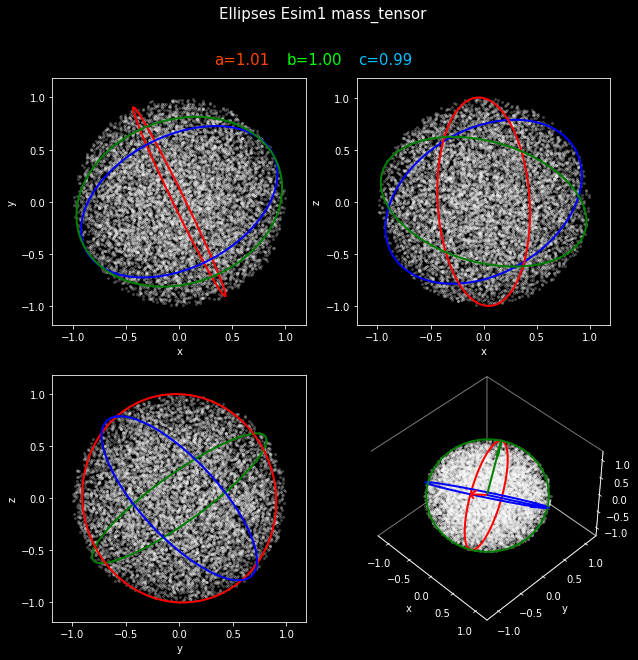

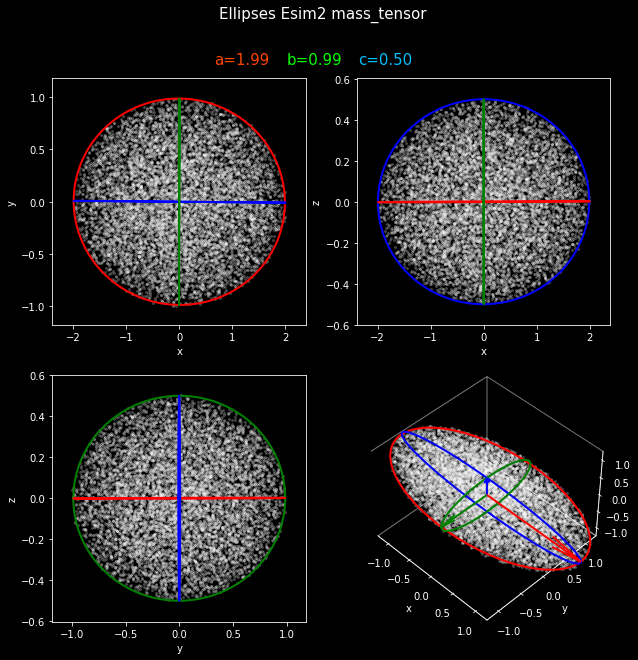

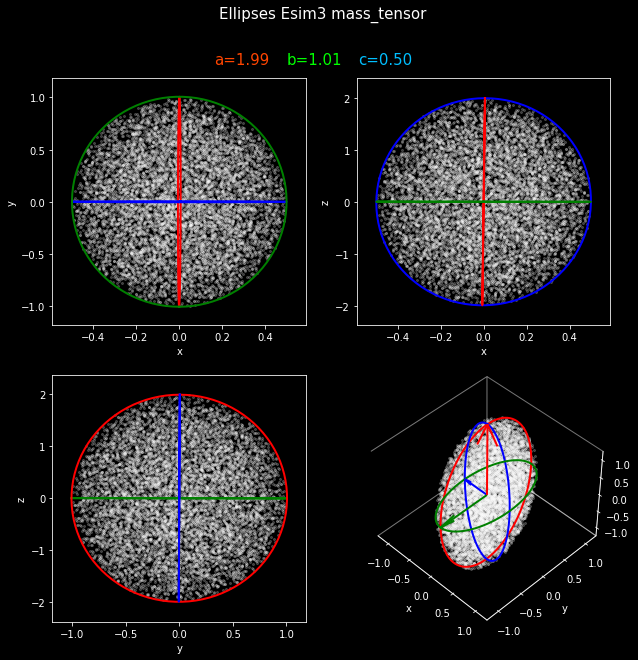

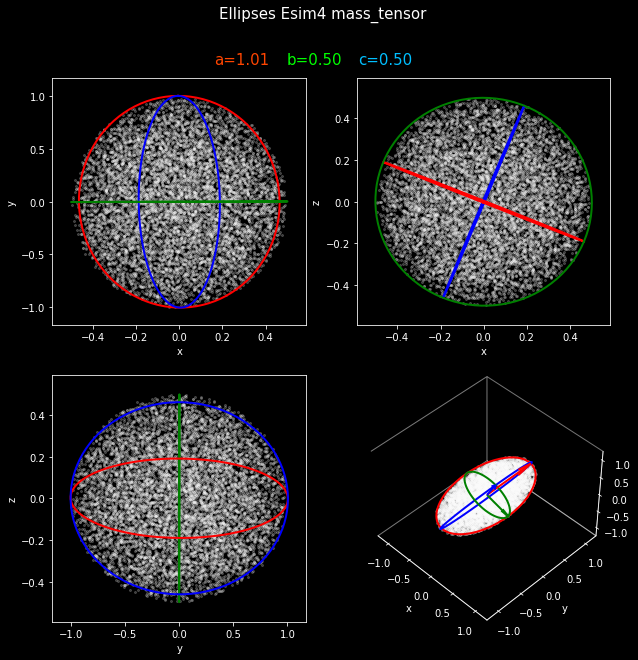

In [4]:
# Generate 
eVal1, eVec1 = mass_tensor(Esim1, testMasses)
eVal2, eVec2 = mass_tensor(Esim2, testMasses)
eVal3, eVec3 = mass_tensor(Esim3, testMasses)
eVal4, eVec4 = mass_tensor(Esim4, testMasses)

plot_ellipsoids(Esim1, testMasses, np.sqrt(eVal1*5), eVec1, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim1 mass_tensor')
plt.show()
plot_ellipsoids(Esim2, testMasses, np.sqrt(eVal2*5), eVec2, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim2 mass_tensor')
plt.show()
plot_ellipsoids(Esim3, testMasses, np.sqrt(eVal3*5), eVec3, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim3 mass_tensor')
plt.show()
plot_ellipsoids(Esim4, testMasses, np.sqrt(eVal4*5), eVec4, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim4 mass_tensor')

#plt.savefig('gradu_theory_kuvat/Elongation_example.jpg',dpi=400)

## Then test Inertia tensor method

I could not find a proper multiplication value for these EigenValues so that it would represent the data nicely. HOWEVER, more important is that the EigenVectors (should be) are same as with the Mass tensor method. This is seen in the next chapter **4**

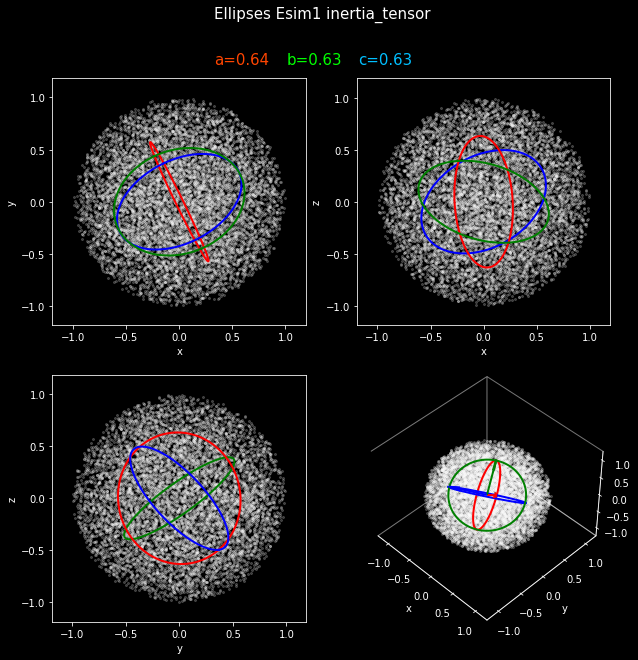

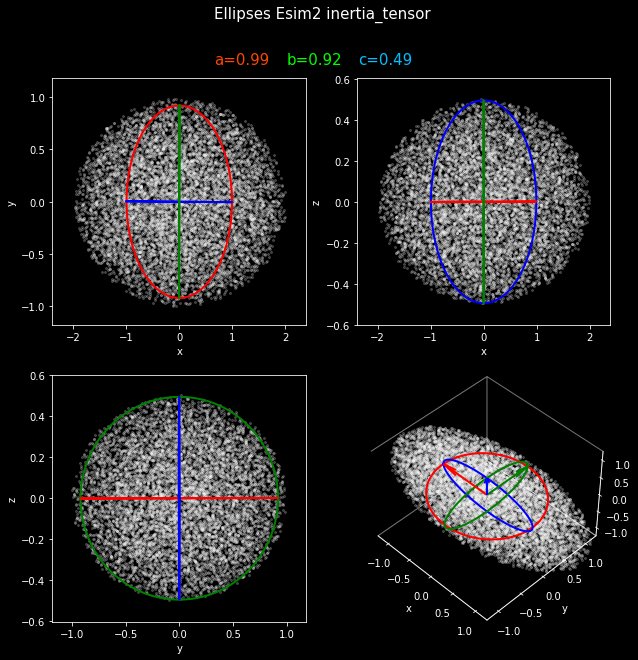

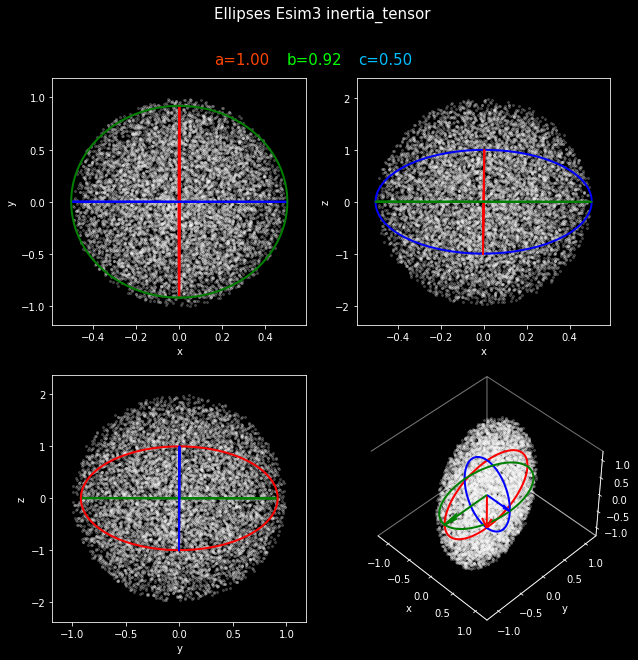

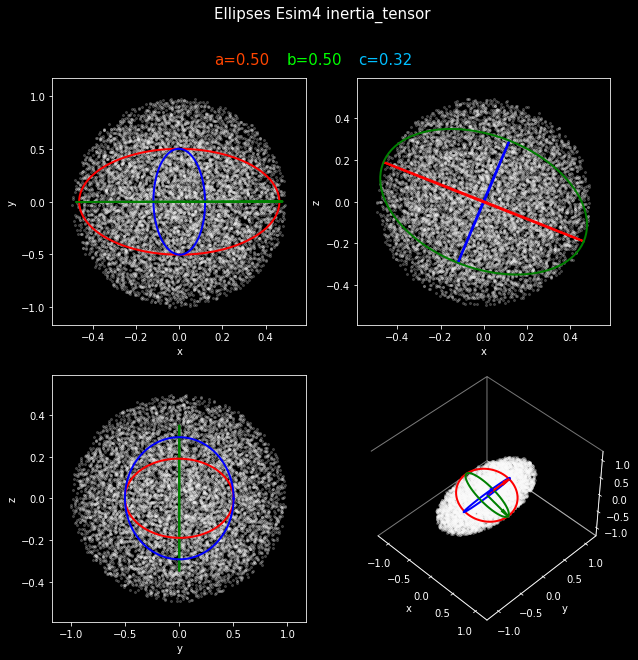

In [5]:
# Generate 
eVal1, eVec1 = inertia_tensor1(Esim1, testMasses)
eVal2, eVec2 = inertia_tensor1(Esim2, testMasses)
eVal3, eVec3 = inertia_tensor1(Esim3, testMasses)
eVal4, eVec4 = inertia_tensor1(Esim4, testMasses)

plot_ellipsoids(Esim1, testMasses, np.sqrt(eVal1), eVec1, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim1 inertia_tensor')
plt.show()
plot_ellipsoids(Esim2, testMasses, np.sqrt(eVal2), eVec2, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim2 inertia_tensor')
plt.show()
plot_ellipsoids(Esim3, testMasses, np.sqrt(eVal3), eVec3, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim3 inertia_tensor')
plt.show()
plot_ellipsoids(Esim4, testMasses, np.sqrt(eVal4), eVec4, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim4 inertia_tensor')

## Lastly PCA method

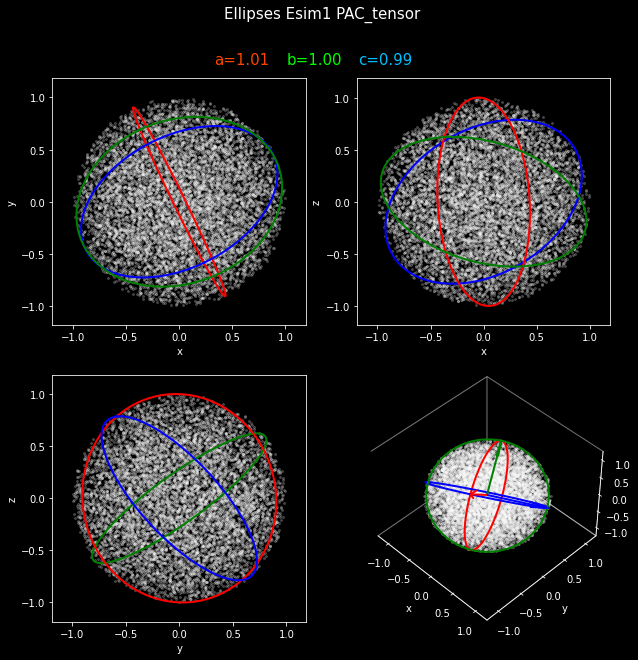

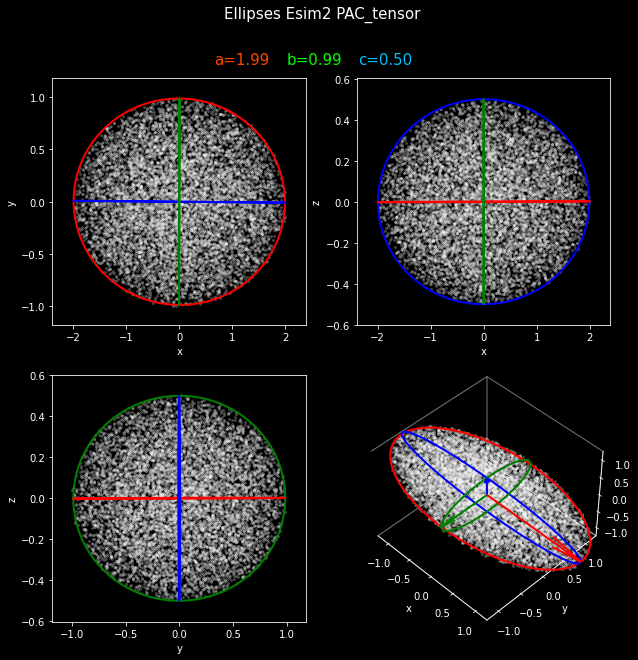

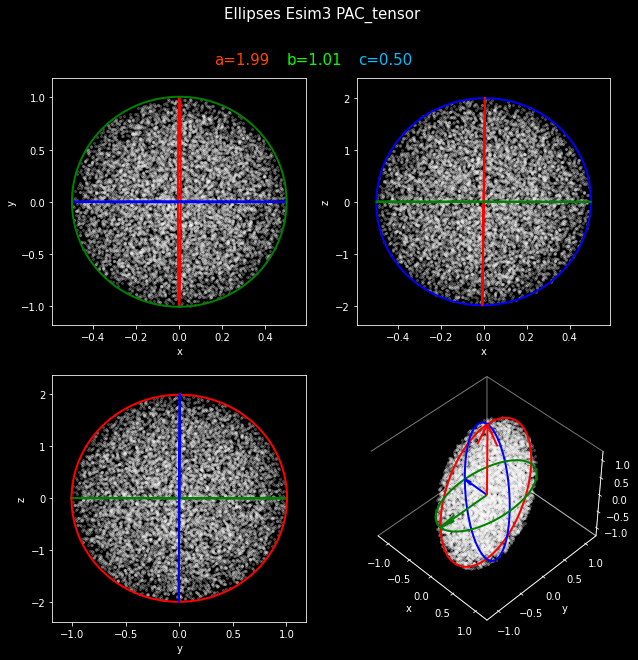

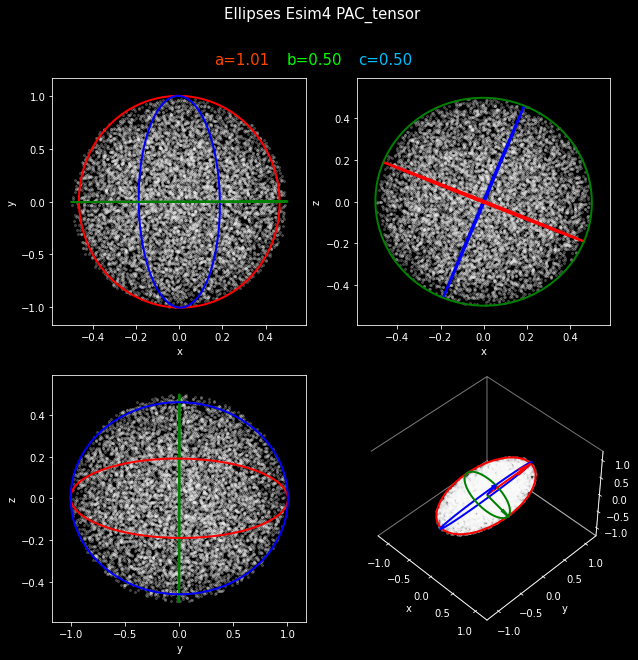

In [6]:
# Generate 
eVal1, eVec1 = PAC_tensor(Esim1)
eVal2, eVec2 = PAC_tensor(Esim2)
eVal3, eVec3 = PAC_tensor(Esim3)
eVal4, eVec4 = PAC_tensor(Esim4)

plot_ellipsoids(Esim1, testMasses, np.sqrt(eVal1*5), eVec1, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim1 PAC_tensor')
plt.show()
plot_ellipsoids(Esim2, testMasses, np.sqrt(eVal2*5), eVec2, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim2 PAC_tensor')
plt.show()
plot_ellipsoids(Esim3, testMasses, np.sqrt(eVal3*5), eVec3, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim3 PAC_tensor')
plt.show()
plot_ellipsoids(Esim4, testMasses, np.sqrt(eVal4*5), eVec4, limscale=1.2, limBox=True, 
                interactivePlot=False,extratitle='Esim4 PAC_tensor')

# Now do things for a single subhalo of interest

## Load Halo and subhalo of interest

In [175]:
haloID = 50
subhaloIndex = 0

# Load Halo and Subhalo informations (masses, locations etc)
with open(fr'TNG_gradu_data_100/haloID_{haloID}/haloinfo_{haloID}.pickle','rb') as f:
    halo_info = pickle.load(f)
    
with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhaloinfo_{haloID}.pickle','rb') as f:
    shalo_info = pickle.load(f)
    
BoxSize = halo_info['BoxSize']    

# Load Subhalo stellar and darkmatter particle coordinates etc
subhaloID = shalo_info['SubhaloID'][subhaloIndex]
print(f'\t\t{haloID= }')
print(f'{subhaloIndex= }  and  {subhaloID= }')

with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhalos/subhalo_dm_{subhaloID}.pickle','rb') as f:
    shalo_dm = pickle.load(f)
    
with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhalos/subhalo_stars_{subhaloID}.pickle','rb') as f:
    shalo_stars = pickle.load(f)

coordStars = shalo_stars['Coordinates'] - halo_info['GroupPos']
coordDM    = shalo_dm['Coordinates'] - halo_info['GroupPos']
galLoc = shalo_info['SubhaloPos'][subhaloIndex] - halo_info['GroupPos']



		haloID= 50
subhaloIndex= 0  and  subhaloID= 206227


## Calculate eigenValues and eigenVectors

In [27]:
# Mass tensor
eVal_Mstar, eVec_Mstar = mass_tensor(coordStars.copy(), shalo_stars['Masses'])
eVal_MDM, eVec_MDM = mass_tensor(coordDM.copy(), np.ones_like(shalo_dm['Potential']))

# PAC method
eVal_PACstar, eVec_PACstar = PAC_tensor(coordStars.copy())
eVal_PACDM, eVec_PACDM = PAC_tensor(coordDM.copy())

# Inertia method
eVal_Istar, eVec_Istar = inertia_tensor(coordStars.copy(), shalo_stars['Masses'])
eVal_IDM, eVec_IDM = inertia_tensor(coordDM.copy(), np.ones_like(shalo_dm['Potential']))


In [28]:
print('\tMass Tensor\n')
print('\teigenValue stars')
print(eVal_Mstar)
print('\teigenVectors stars')
print(eVec_Mstar)

print()
print('\teigenValue DM')
print(eVal_MDM)
print('\teigenVectors DM')
print(eVec_MDM)

print('--------------------------')
print('\tPAC Tensor\n')
print('\teigenValue stars')
print(eVal_PACstar)
print('\teigenVectors stars')
print(eVec_PACstar)

print()
print('\teigenValue DM')
print(eVal_PACDM)
print('\teigenVectors DM')
print(eVec_PACDM)

print('--------------------------')
print('\tInertia Tensor\n')
print('\teigenValue stars')
print(eVal_Istar)
print('\teigenVectors stars')
print(eVec_Istar)

print()
print('\teigenValue DM')
print(eVal_IDM)
print('\teigenVectors DM')
print(eVec_IDM)


	Mass Tensor

	eigenValue stars
[2.97752663 2.69979262 1.94372806]
	eigenVectors stars
[[ 0.60653098 -0.04384409 -0.79385003]
 [ 0.36243174 -0.87345263  0.32515186]
 [ 0.70764638  0.48493112  0.51388559]]

	eigenValue DM
[34.7995017  28.83352933 26.63953724]
	eigenVectors DM
[[-0.63832937 -0.25677461 -0.72567376]
 [-0.36500705 -0.7290314   0.57903633]
 [-0.67772079  0.63449194  0.37163761]]
--------------------------
	PAC Tensor

	eigenValue stars
[2.81115471 2.566282   1.80908206]
	eigenVectors stars
[[ 0.59603906 -0.05668278 -0.80095225]
 [ 0.31019141 -0.90381255  0.29479511]
 [ 0.7406205   0.42415791  0.52112507]]

	eigenValue DM
[34.80118707 28.83492576 26.64082742]
	eigenVectors DM
[[-0.63832937 -0.25677461 -0.72567376]
 [-0.36500705 -0.7290314   0.57903633]
 [-0.67772079  0.63449194  0.37163761]]
--------------------------
	Inertia Tensor

	eigenValue stars
[5.67731924 4.92125469 4.64352068]
	eigenVectors stars
[[-0.60653098 -0.04384409  0.79385003]
 [-0.36243174 -0.87345263 -0.3

## lets do a vidual check if ellipses seems correct

### Mass tensor method


[-0.75341832 -0.01676429 -0.65732777]


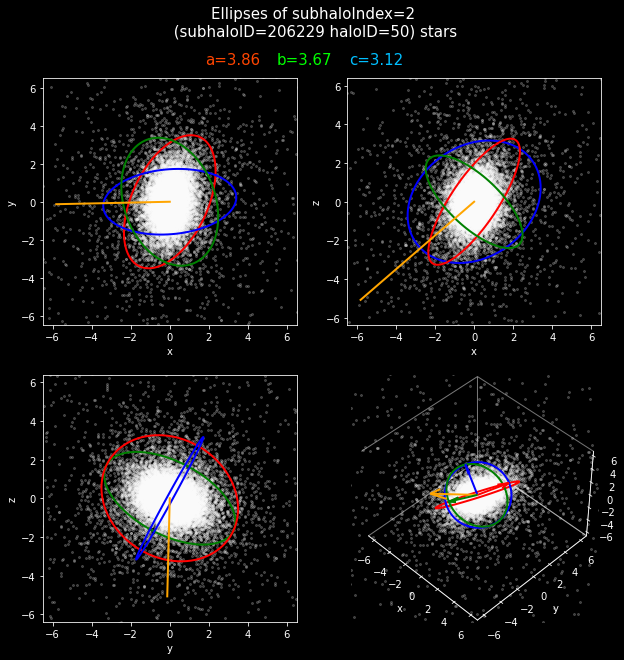

In [12]:
plot_ellipsoids(coordStars, shalo_stars['Masses'], np.sqrt(eVal_Mstar*5), eVec_Mstar,
               subhaloIndex=subhaloIndex,subhaloID=subhaloID,haloID=haloID,
               particle='stars',plotCenterLoc=True, limscale=0.3, interactivePlot=False)

### Inertia tensor method

[-0.75341832 -0.01676429 -0.65732777]


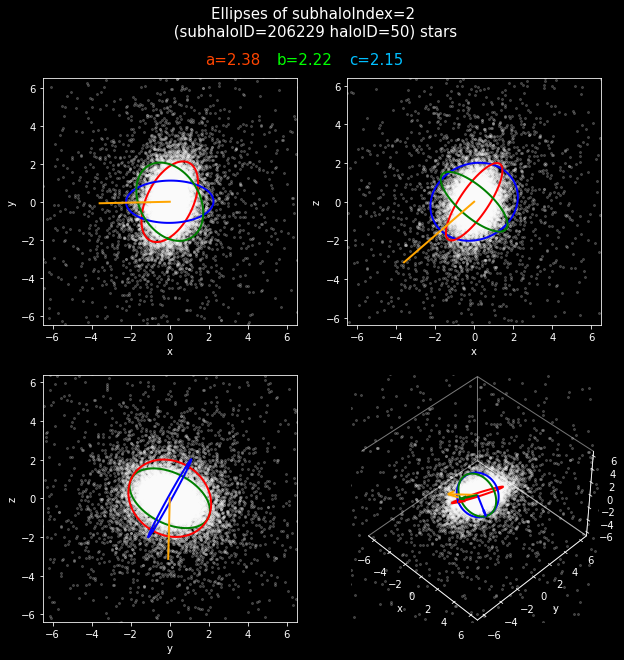

In [13]:
plot_ellipsoids(coordStars, shalo_stars['Masses'], np.sqrt(eVal_Istar), eVec_Istar,
               subhaloIndex=subhaloIndex,subhaloID=subhaloID,haloID=haloID,
               particle='stars',plotCenterLoc=True, limscale=0.3, interactivePlot=False)

### PAC method

[-0.75341832 -0.01676429 -0.65732777]


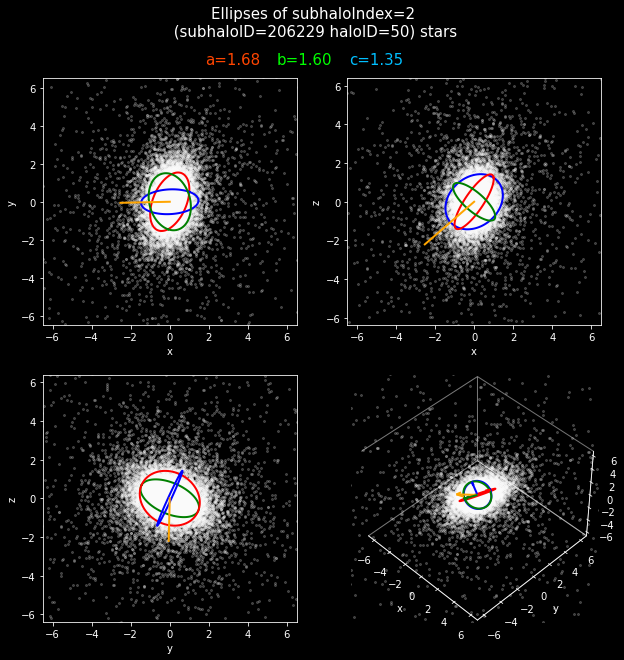

In [14]:
plot_ellipsoids(coordStars, shalo_stars['Masses'], np.sqrt(eVal_PACstar), eVec_PACstar,
               subhaloIndex=subhaloIndex,subhaloID=subhaloID,haloID=haloID,
               particle='stars',plotCenterLoc=True, limscale=0.3, interactivePlot=False)

# Calculate EigenVectors, EigenValues and Elongation for each Subhalo from each Halo

In [3]:
particles = ['Stars','DM']  # We choose which particles we want to take into account
percentile = 100             # One can choose the percentile of particles taken into account (by distance)
function = mass_tensor      # One can choose which function to use
                            #      mass_tensor, inertia_tensor, PAC_tensor

ba_lim = 0.9 # b/a limit. If b/a < limit, it is taken into account
# The structure of dataTree is following 
dataTree = {
    'Stars' : {
        'EigenValue'    :[],  # Eigen values a b c
        'EigenVector'   :[],  # Eigen vectors 
        'Angles3D_rad'  :[],  # 3D angles eigenVec vs pos_vec in radians
        'Angles3D_deg'  :[],  # same in degrees
        'Angles3D_deg_n':[],  # Degrees normalized to 0-90 degrees
        'Angles3D_COS'  :[],  # cos(theta) = np.dot(v,r)/(|v|*|r|)
        'Flag'          :[],  # Is b/a < 0.8 True if yes, false if no
        'Count'         :[],  # Number of particles,
        'AngularVector' :[],  # Angular (spin) vector of the galaxy disc for particle  
        'DotValSpin'    :[]   # dot product between disc and galaxy angular(spin) vector
    },
    
    'DM' : {
        'EigenValue'    :[],
        'EigenVector'   :[],
        'Angles3D_rad'  :[],  # 3D angles eigenVec vs pos_vec in radians
        'Angles3D_deg'  :[],  # same in degrees
        'Angles3D_deg_n':[],  # Degrees normalized to 0-90 degrees
        'Angles3D_COS'  :[],  # cos(theta) = np.dot(v,r)/(|v|*|r|)
        'Flag'          :[],  # Is b/a < 0.8 True if yes, false if no
        'Count'         :[],  # Number of particles,
        'AngularVector' :[],  # Angular (spin) vector of the galaxy disc for particle
        'DotValSpin'    :[]   # dot product between disc and galaxy angular(spin) vector
    },
    
    'Properties' : {
        'SubhaloLoc'   : [],  # Location of the subhalo in the coordinates of Halo
        'SubhaloVel'   : [],  # Velocity of the subhalo -||-
        'SubhaloIndex' : [],  # The index of subhalo
        'SubhaloID'    : [],  # ID of subhalo
        'SubhaloAngVec': [],   # Angular(spin) vector of Subhalo
        'HaloID'       : [], 
        'HaloR200'     : []
    },
    
    'Infos' : {
        'function'   : function.__name__,  # Name of the used function to determine distribution of particles
        'percentile' : percentile,         # What percentile settings has been used
        'ba_lim'     : ba_lim              # The limit of b/a that is taken into account
    }
}



for haloID in [8,17,22,35,39,50,51,69]:
    print(haloID)
    with open(fr'TNG_gradu_data_100/haloID_{haloID}/haloinfo_{haloID}.pickle','rb') as f:
        halo_info = pickle.load(f)

    with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhaloinfo_{haloID}.pickle','rb') as f:
        shalo_info = pickle.load(f)

    BoxSize = halo_info['BoxSize']    

    



    # slice(start,end,step), if end=None then we go all the way to the end
    chosen_gals = slice(0,None,1) 

    # Lets go through each Subhalo in the Halo
    # The itertools.islice() function is similar to the enumerate, but take steps into account. Using this the indexing stays
    #     correct if using steps
    for subhaloIndex, subhaloID in islice(enumerate(shalo_info['SubhaloID']), chosen_gals.start,chosen_gals.stop, chosen_gals.step):
        print(f'{subhaloIndex=}  {subhaloID=}')
        # for subhaloIndex , subhaloID in enumerate(shalo_info['SubhaloID'][chosen_gals]):

        # Load the particle information for stellar and DM components
        with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhalos/subhalo_dm_{subhaloID}.pickle','rb') as f:
            shalo_dm = pickle.load(f)

        with open(fr'TNG_gradu_data_100/haloID_{haloID}/subhalos/subhalo_stars_{subhaloID}.pickle','rb') as f:
            shalo_stars = pickle.load(f)

        # Loop through both particles
        for particle in particles:

            # Get the coordinates and masses based on particle type in Halo coordinate system
            if particle == 'Stars':
                coordinates = shalo_stars['Coordinates'] - halo_info['GroupPos']
                velocities  = shalo_stars['Velocities']  - halo_info['GroupVel']
                masses = shalo_stars['Masses'].copy()

            if particle == 'DM':
                coordinates= shalo_dm['Coordinates']  - halo_info['GroupPos']
                velocities  = shalo_dm['Velocities']  - halo_info['GroupVel']
                masses = np.ones_like(shalo_dm['Potential']) 

            # Calculate center of subhalo and velocity
            galCenter = shalo_info['SubhaloPos'][subhaloIndex] - halo_info['GroupPos']
            galVel    = shalo_info['SubhaloVel'][subhaloIndex] - halo_info['GroupVel']

            # particles to the subhalo coordinate system
            coords = coordinates - galCenter
            vels   = velocities  - galVel

            # Distances of particles to the center of subhalo
            rr_com = np.sqrt(np.sum(coords**2,axis=1))
            rr_com_cut = np.percentile(rr_com, percentile) 

            if percentile == 100:
                index = slice(0,len(rr_com))
            else:
                index = np.where(rr_com < rr_com_cut)[0]


            # Calculate EigenValues and EigenVectors
            if function.__name__ == 'PAC_tensor':
                eigenVal, eigenVec = function(coords[index])
            else:
                eigenVal, eigenVec = function(coords[index], masses[index])

            # Lets take some condition into account. If b/a >0.9, the 'subhalo' is discarded
            if eigenVal[1]/eigenVal[0] < ba_lim : # and eigenVal[2]/eigenVal[1]<0.9:  
                
                dataTree[particle]['Flag'].append(True) # Flag = True , those ones are taken into account later
            else:
                dataTree[particle]['Flag'].append(False) # Flag = False, are not taken into account later

            # Save data into dataTree
            dataTree[particle]['EigenValue'].append(eigenVal)
            dataTree[particle]['EigenVector'].append(eigenVec)

            # Position vector to Halo center
            r_vec = np.array([0,0,0]) - galCenter
            r_vec_unit = r_vec/np.linalg.norm(r_vec) 

            # Lets append 3D angles between EigenVectors and the position vector
            # These are in radians, degrees, and cos(theta)= np.dot(v,r)/(|v|*|r|)
            dataTree[particle]['Angles3D_rad'].append( calc3D_AngleRad(eigenVec.T, r_vec_unit) ) 
            dataTree[particle]['Angles3D_deg'].append( calc3D_AngleDeg(eigenVec.T, r_vec_unit) )
            #temp = calc3D_AngleDeg(eigenVec.T, r_vec_unit)
            #temp[temp>90] = 180-temp[temp>90] 
            #dataTree[particle]['Angles3D_deg_n'].append( temp  )
            dataTree[particle]['Angles3D_COS'].append( calc3D_cosAngle(eigenVec.T, r_vec_unit, absVal=True) )

            dataTree[particle]['Count'].append(len(rr_com[index]))

            # Calculate the angular (spin) vector of the dics/particles
            L_disc = np.sum(np.cross(coords,vels),axis=0)
            L_disc_norm = L_disc/np.linalg.norm(L_disc)

            L_gal = np.cross(galCenter,galVel)
            L_gal_norm = L_gal / np.linalg.norm(L_gal)

            dot_val = np.dot(L_gal_norm,L_disc_norm)

            dataTree[particle]['AngularVector'].append(L_disc_norm)
            dataTree[particle]['DotValSpin'].append(dot_val)




        dataTree['Properties']['SubhaloLoc'].append(galCenter)
        dataTree['Properties']['SubhaloIndex'].append(subhaloIndex)
        dataTree['Properties']['SubhaloID'].append(subhaloID)
        dataTree['Properties']['SubhaloAngVec'].append(L_gal_norm)
        dataTree['Properties']['HaloID'].append(haloID)
        dataTree['Properties']['HaloR200'].append(halo_info['Group_R_Crit200'])
        print('Done\n')



for particle in particles:
    for key in dataTree[particle]:
        dataTree[particle][key] = np.array(dataTree[particle][key]) 

for key in dataTree['Properties']:
    dataTree['Properties'][key] = np.array(dataTree['Properties'][key]) 


8
subhaloIndex=0  subhaloID=83281
Done

subhaloIndex=1  subhaloID=83282
Done

subhaloIndex=2  subhaloID=83283
Done

subhaloIndex=3  subhaloID=83284
Done

subhaloIndex=4  subhaloID=83285
Done

subhaloIndex=5  subhaloID=83286
Done

subhaloIndex=6  subhaloID=83287
Done

subhaloIndex=7  subhaloID=83288
Done

subhaloIndex=8  subhaloID=83289
Done

subhaloIndex=9  subhaloID=83290
Done

subhaloIndex=10  subhaloID=83291
Done

subhaloIndex=11  subhaloID=83292
Done

subhaloIndex=12  subhaloID=83293
Done

subhaloIndex=13  subhaloID=83294
Done

subhaloIndex=14  subhaloID=83295
Done

subhaloIndex=15  subhaloID=83296
Done

subhaloIndex=16  subhaloID=83297
Done

subhaloIndex=17  subhaloID=83298
Done

subhaloIndex=18  subhaloID=83299
Done

subhaloIndex=19  subhaloID=83300
Done

subhaloIndex=20  subhaloID=83301
Done

subhaloIndex=21  subhaloID=83302
Done

subhaloIndex=22  subhaloID=83303
Done

subhaloIndex=23  subhaloID=83304
Done

subhaloIndex=24  subhaloID=83305
Done

subhaloIndex=25  subhaloID=83306


Done

subhaloIndex=211  subhaloID=83802
Done

subhaloIndex=212  subhaloID=83809
Done

subhaloIndex=213  subhaloID=83818
Done

subhaloIndex=214  subhaloID=83836
Done

subhaloIndex=215  subhaloID=83847
Done

subhaloIndex=216  subhaloID=83919
Done

subhaloIndex=217  subhaloID=83980
Done

subhaloIndex=218  subhaloID=83990
Done

subhaloIndex=219  subhaloID=84056
Done

subhaloIndex=220  subhaloID=84066
Done

subhaloIndex=221  subhaloID=84116
Done

subhaloIndex=222  subhaloID=84162
Done

17
subhaloIndex=0  subhaloID=128394
Done

subhaloIndex=1  subhaloID=128395
Done

subhaloIndex=2  subhaloID=128396
Done

subhaloIndex=3  subhaloID=128397
Done

subhaloIndex=4  subhaloID=128398
Done

subhaloIndex=5  subhaloID=128399
Done

subhaloIndex=6  subhaloID=128400
Done

subhaloIndex=7  subhaloID=128401
Done

subhaloIndex=8  subhaloID=128402
Done

subhaloIndex=9  subhaloID=128403
Done

subhaloIndex=10  subhaloID=128404
Done

subhaloIndex=11  subhaloID=128405
Done

subhaloIndex=12  subhaloID=128406
Done

s

Done

subhaloIndex=77  subhaloID=144006
Done

subhaloIndex=78  subhaloID=144007
Done

subhaloIndex=79  subhaloID=144011
Done

subhaloIndex=80  subhaloID=144013
Done

subhaloIndex=81  subhaloID=144016
Done

subhaloIndex=82  subhaloID=144018
Done

subhaloIndex=83  subhaloID=144027
Done

subhaloIndex=84  subhaloID=144033
Done

subhaloIndex=85  subhaloID=144034
Done

subhaloIndex=86  subhaloID=144042
Done

subhaloIndex=87  subhaloID=144046
Done

subhaloIndex=88  subhaloID=144057
Done

subhaloIndex=89  subhaloID=144059
Done

subhaloIndex=90  subhaloID=144068
Done

subhaloIndex=91  subhaloID=144091
Done

subhaloIndex=92  subhaloID=144096
Done

subhaloIndex=93  subhaloID=144097
Done

subhaloIndex=94  subhaloID=144109
Done

subhaloIndex=95  subhaloID=144117
Done

subhaloIndex=96  subhaloID=144148
Done

subhaloIndex=97  subhaloID=144192
Done

subhaloIndex=98  subhaloID=144251
Done

35
subhaloIndex=0  subhaloID=175239
Done

subhaloIndex=1  subhaloID=175240
Done

subhaloIndex=2  subhaloID=175241


Done

subhaloIndex=6  subhaloID=207480
Done

subhaloIndex=7  subhaloID=207481
Done

subhaloIndex=8  subhaloID=207482
Done

subhaloIndex=9  subhaloID=207483
Done

subhaloIndex=10  subhaloID=207484
Done

subhaloIndex=11  subhaloID=207485
Done

subhaloIndex=12  subhaloID=207486
Done

subhaloIndex=13  subhaloID=207487
Done

subhaloIndex=14  subhaloID=207488
Done

subhaloIndex=15  subhaloID=207489
Done

subhaloIndex=16  subhaloID=207490
Done

subhaloIndex=17  subhaloID=207491
Done

subhaloIndex=18  subhaloID=207492
Done

subhaloIndex=19  subhaloID=207493
Done

subhaloIndex=20  subhaloID=207494
Done

subhaloIndex=21  subhaloID=207495
Done

subhaloIndex=22  subhaloID=207496
Done

subhaloIndex=23  subhaloID=207497
Done

subhaloIndex=24  subhaloID=207498
Done

subhaloIndex=25  subhaloID=207500
Done

subhaloIndex=26  subhaloID=207501
Done

subhaloIndex=27  subhaloID=207504
Done

subhaloIndex=28  subhaloID=207506
Done

subhaloIndex=29  subhaloID=207508
Done

subhaloIndex=30  subhaloID=207509
Done

In [4]:
subhalos_halo50 = np.where(dataTree['Properties']['HaloID']==50)[0]  # all subhalos from haloID=50 
subhalos_all_stars = np.where(dataTree['Stars']['Flag']==True)[0]    # all stars-subhalos from all haloIDs that have flag=True
subhalos_all_DM = np.where(dataTree['DM']['Flag']==True)[0]          # all DMs-subhalos from all haloIDs that have flag=True

print(len(subhalos_all_stars), len(subhalos_all_DM))

subhalos_halo50_stars = np.where( (dataTree['Properties']['HaloID']==50) & (dataTree['Stars']['Flag']==True) )[0] # stars-subhalos from haloID=50
print(len(subhalos_halo50_stars) , '/', len(subhalos_halo50))

subhalos_halo50_DM = np.where( (dataTree['Properties']['HaloID']==50) & (dataTree['DM']['Flag']==True) )[0] # DM-subhalos from haloID=50
print(len(subhalos_halo50_DM) , '/', len(subhalos_halo50))

610 667
36 / 40
37 / 40


610 667
36 / 40
37 / 40


Text(0, 0.5, 'Percentage %')

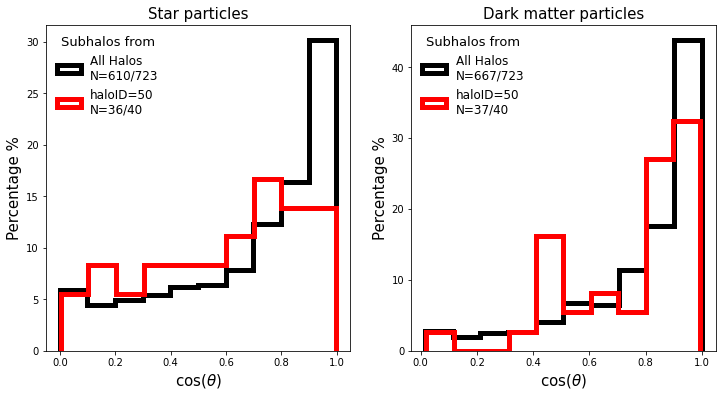

In [350]:
#prepping
subhalos_halo50 = np.where(dataTree['Properties']['HaloID']==50)[0]  # all subhalos from haloID=50 
subhalos_all_stars = np.where(dataTree['Stars']['Flag']==True)[0]    # all stars-subhalos from all haloIDs that have flag=True
subhalos_all_DM = np.where(dataTree['DM']['Flag']==True)[0]          # all DMs-subhalos from all haloIDs that have flag=True

print(len(subhalos_all_stars), len(subhalos_all_DM))

subhalos_halo50_stars = np.where( (dataTree['Properties']['HaloID']==50) & (dataTree['Stars']['Flag']==True) )[0] # stars-subhalos from haloID=50
print(len(subhalos_halo50_stars) , '/', len(subhalos_halo50))

subhalos_halo50_DM = np.where( (dataTree['Properties']['HaloID']==50) & (dataTree['DM']['Flag']==True) )[0] # DM-subhalos from haloID=50
print(len(subhalos_halo50_DM) , '/', len(subhalos_halo50))

# Figure stuff


weights_all_stars = np.ones_like(dataTree['Stars']['Angles3D_COS'][subhalos_all_stars,0]) / len(dataTree['Stars']['Angles3D_COS'][subhalos_all_stars,0]) *100
weights_50_stars  =  np.ones_like(dataTree['Stars']['Angles3D_COS'][subhalos_halo50_stars,0]) / len(dataTree['Stars']['Angles3D_COS'][subhalos_halo50_stars,0])*100

weights_all_DM = np.ones_like(dataTree['DM']['Angles3D_COS'][:,0][subhalos_all_DM]) / len(dataTree['DM']['Angles3D_COS'][:,0][subhalos_all_DM]) *100
weights_50_DM  =  np.ones_like(dataTree['DM']['Angles3D_COS'][subhalos_halo50_DM,0]) / len(dataTree['DM']['Angles3D_COS'][subhalos_halo50_DM,0])*100


fig,axs = plt.subplots(1,2,figsize=(12,6))

axs[0].hist(dataTree['Stars']['Angles3D_COS'][:,0][subhalos_all_stars],weights=weights_all_stars,
         histtype='step',linewidth=5, color='black',
         label=f'All Halos\nN={len(dataTree["Properties"]["HaloID"][subhalos_all_stars])}/{len(dataTree["Properties"]["HaloID"])}')


axs[0].hist(dataTree['Stars']['Angles3D_COS'][subhalos_halo50_stars,0], weights=weights_50_stars,
         color='red',histtype='step',linewidth=5,
        label=f'haloID=50\nN={len(subhalos_halo50_stars)}/{len(subhalos_halo50)}')

axs[0].legend(loc='upper left',title='Subhalos from',framealpha=0,
           fontsize=12, title_fontsize=13)

axs[0].set_title('Star particles',fontsize=15)
axs[0].set_xlabel(r'cos($\theta$)',fontsize = 15)
axs[0].set_ylabel(r'Percentage %', fontsize = 15)



axs[1].hist(dataTree['DM']['Angles3D_COS'][:,0][subhalos_all_DM], weights=weights_all_DM,
         histtype='step',linewidth=5, color='black',
         label=f'All Halos\nN={len(dataTree["Properties"]["HaloID"][subhalos_all_DM])}/{len(dataTree["Properties"]["HaloID"])}')


axs[1].hist(dataTree['DM']['Angles3D_COS'][subhalos_halo50_DM,0], weights=weights_50_DM,
         color='red',histtype='step',linewidth=5,
        label=f'haloID=50\nN={len(subhalos_halo50_DM)}/{len(subhalos_halo50)}')

axs[1].legend(loc='upper left',title='Subhalos from',framealpha=0,
           fontsize=12, title_fontsize=13)

axs[1].set_title('Dark matter particles',fontsize=15)
axs[1].set_xlabel(r'cos($\theta$)',fontsize = 15)
axs[1].set_ylabel(r'Percentage %', fontsize = 15)



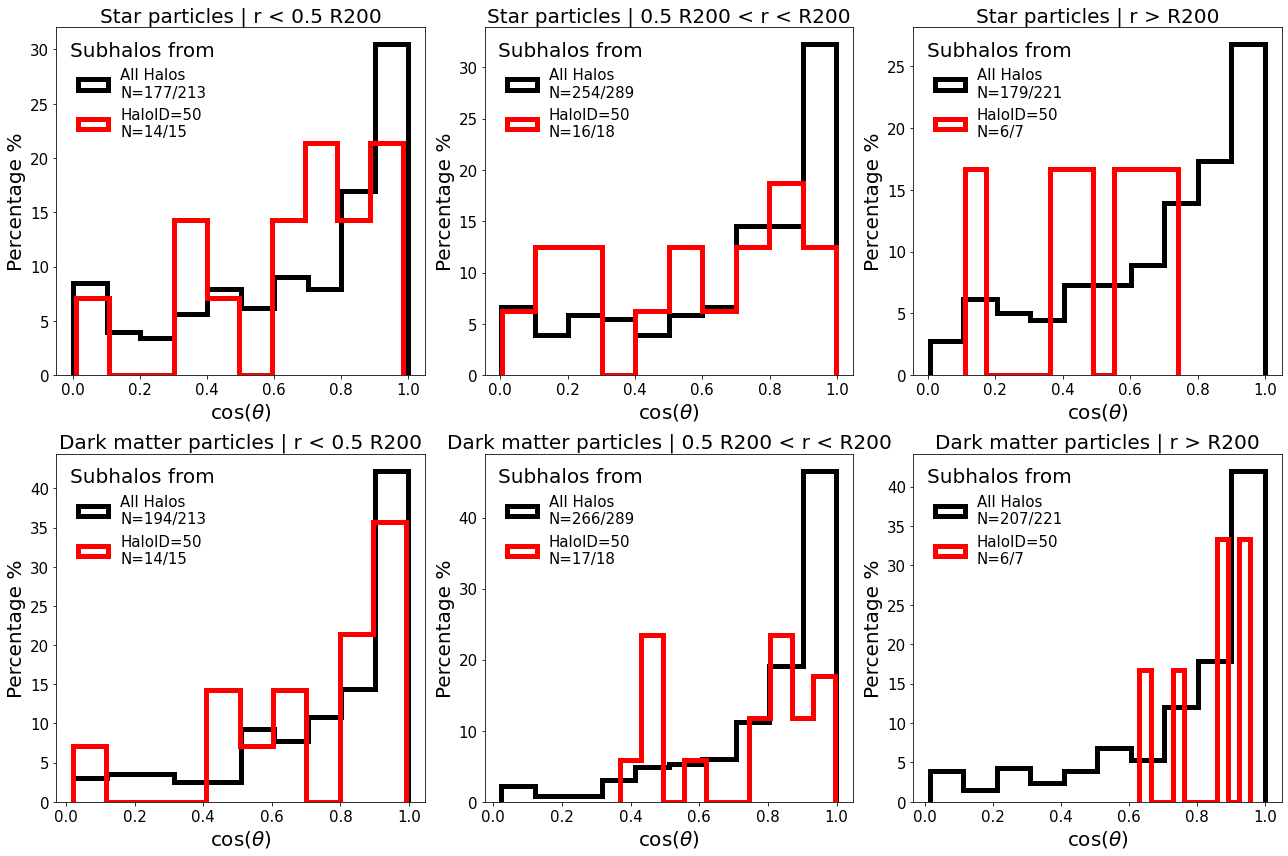

In [571]:
def calculate_weights(data_len):
    return np.ones_like(data_len) / len(data_len) * 100

# Extract necessary data

stars_cos_angle = dataTree['Stars']['Angles3D_COS'][:,0]
DM_cos_angle = dataTree['DM']['Angles3D_COS'][:,0]


# Define distance bins
dist_bins = [0, 0.5, 1, np.inf]

# Calculate distances to the center for all subhalos
distances = np.sqrt(np.sum(dataTree['Properties']['SubhaloLoc']**2, axis=1))

# Normalize the distances by the halo radius (HaloR200)
normalized_distances = distances / dataTree['Properties']['HaloR200']

# Create array to store the bin indices for each subhalo's distance
dist_bin_indices = np.zeros_like(normalized_distances)

# Set the bin indices based on the normalized distances
dist_bin_indices[normalized_distances < 0.5] = 1
dist_bin_indices[(normalized_distances >= 0.5) & (normalized_distances <= 1)] = 2
dist_bin_indices[normalized_distances > 1] = 3

dist_bin_indices_flag_stars = dist_bin_indices.copy()
dist_bin_indices_flag_stars[dataTree['Stars']['Flag']==False] = -1
dist_bin_indices_flag_DM = dist_bin_indices.copy()
dist_bin_indices_flag_DM[dataTree['DM']['Flag']==False] = -1

# Then repeat above steps for haloID=50 data
selected_haloID = 50
haloID_50_indices = np.where(dataTree['Properties']['HaloID'] == selected_haloID)[0]
distances_50 = np.sqrt(np.sum(dataTree['Properties']['SubhaloLoc'][haloID_50_indices]**2, axis=1))
normalized_distances_50 = distances_50 / dataTree['Properties']['HaloR200'][haloID_50_indices]
dist_bin_indices_50 = np.zeros_like(normalized_distances_50)
dist_bin_indices_50[normalized_distances_50 < 0.5] = 1
dist_bin_indices_50[(normalized_distances_50 >= 0.5) & (normalized_distances_50 <= 1)] = 2
dist_bin_indices_50[normalized_distances_50 > 1] = 3

dist_bin_indices_50_flag_stars = dist_bin_indices_50.copy()
dist_bin_indices_50_flag_stars[dataTree['Stars']['Flag'][haloID_50_indices]==False] = -1
dist_bin_indices_50_flag_DM = dist_bin_indices_50.copy()
dist_bin_indices_50_flag_DM[dataTree['DM']['Flag'][haloID_50_indices]==False] = -1

# Add the rest of the code that I provided earlier here...


# Create 2x3 subplots
fig, axs = plt.subplots(2,3,figsize=(18,12))

cos_angles = [stars_cos_angle, DM_cos_angle]
dist_bin_type = [dist_bin_indices_flag_stars, dist_bin_indices_flag_DM]
dist_bin_type2 = [dist_bin_indices_50_flag_stars, dist_bin_indices_50_flag_DM]
colors = ['black','red']
labels = ['All Halos', 'HaloID=50']
particle_type = ['Star','Dark matter']
bin_labels = ['r < 0.5 R200', '0.5 R200 < r < R200', 'r > R200']
for i in range(2):
    for j in range(1,4):
        axs[i][j-1].hist( cos_angles[i][dist_bin_type[i]==j], weights=calculate_weights(cos_angles[i][dist_bin_type[i]==j]),
                          histtype='step',color='black', linewidth=5,
                          label=f'{labels[0]}\nN={len(cos_angles[i][dist_bin_type[i]==j])}/{len(cos_angles[i][dist_bin_indices==j])}')

        axs[i][j-1].hist( cos_angles[i][haloID_50_indices][dist_bin_type2[i]==j],
                         weights=calculate_weights(cos_angles[i][haloID_50_indices][dist_bin_type2[i]==j]),
                          histtype='step',color='red', linewidth=5,
                          label=f'{labels[1]}\nN={len(cos_angles[i][haloID_50_indices][dist_bin_type2[i]==j])}/{len(cos_angles[i][haloID_50_indices][dist_bin_indices_50==j])}',
                        )

        #print(particle_type[i] , haloID_50_indices[dist_bin_type2[i]==j])
        
        axs[i, j-1].set_xlabel(r'cos($\theta$)',fontsize = 20)
        axs[i, j-1].set_ylabel(r'Percentage %', fontsize = 20)
        axs[i, j-1].set_title(f'{particle_type[i]} particles | {bin_labels[j-1]}', fontsize=20)
        axs[i, j-1].legend(loc='upper left', title='Subhalos from', framealpha=0, fontsize=15, title_fontsize=20)
        axs[i, j-1].tick_params(axis='both', which='major', labelsize=15)
        #axs[i, j-1].set_ylim(0,50)
fig.tight_layout()

#plt.savefig('gradu_theory_kuvat/Stars_DMs_elongation_distance.jpg',dpi=400)